# Elliptic Curves

**Note: due to the context of this being explained during Sage days, I assume you are all running the most up to date version of SageMath at the time of writing (version 10.2)**

Before jumping straight to isogenies, let's look at how we can create and work with elliptic curves in sage. This will include how we construct rings and fields, different curve models, the arithemtic of points on curves and how we can compute things such as the j-invariant.

To begin, let's construct elliptic curves themselves and use Sage's in-built plotting for some visual aid. By default, elliptic curves are constructed over the rationals. Note that familiar fields and rings such as the Reals, Rationals, Complex numbers and integers can be accessed by `RR`, `QQ`, `CC` and `ZZ` respectively.

Elliptic Curve defined by y^2 = x^3 + 3*x + 5 over Rational Field


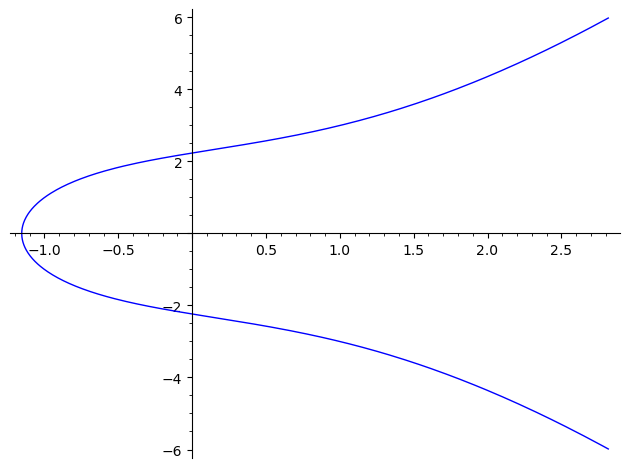

In [1]:
E = EllipticCurve([3, 5])
assert E is EllipticCurve(QQ, [3, 5])
print(E)
E.plot()

To construct and elliptic curve $E / \mathbb{F}_p$, we must first construct the finite field $\mathbb{F}_p$. This is done with a call to `FiniteField(p)`, or for short hand we can type `GF(p)` with GF for Galois Field. Once we have the field constructed we can pass it as an argument into `EllipticCurve(F, [a, b])` to create an elliptic curve in short Weierstrass form.

Elliptic Curve defined by y^2 = x^3 + x over Finite Field of size 19


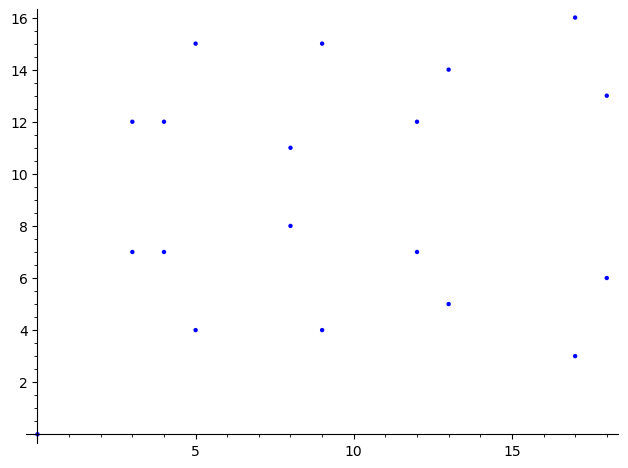

In [2]:
F = GF(19)
assert F is FiniteField(19)
# Now we can construct the curve over F and plot the Fp rational points
E = EllipticCurve(F, [1, 0])
print(E)
E.plot()

### Extension Fields

Often in isogeny world, we want to work in extension fields. Asking for a generic extension is as easy as defining the field `F = GF(p^k)` and we can obtain the generator of the field from `F.gen()`. By default sage will pick the irreducible polynomial of degree `k` for us, but we can pick this ourselves too, which is helpful when for example we want the polynomial $x^2 + 1$, which is used a lot in isogeny world.

In [43]:
# Here sage will pick the modulus for us
F = GF(19^2)
print(F.modulus())
print(F.random_element())
print(F.gen())

x^2 + 18*x + 2
3*z2 + 2
z2


Note that when we define the modulus, we must also give a name to the generator. One way to do this is the following:

In [49]:
F = GF(19^2, name="i", modulus=x^2 + 1)
print(F.modulus())
print(F.random_element())
print(F.gen())

x^2 + 1
15*i + 12
i


Alternatively, we can do this in one shot with a special SageMath syntax which is not valid python and may remind users more of Magma notation:

In [48]:
F.<i> = GF(19^2, modulus=x^2 + 1)
print(F.modulus())
print(F.random_element())
print(F.gen())

x^2 + 1
15*i + 5
i


## Different Curve Models

For most use cases you will create an elliptic curve as above, with `E = EllipticCurve(F, [a,b])` where `a,b` are the coefficients of the curve in short Weierstrass form. Sage however allows the construction from all five a-invariants:

In [50]:
E_short = EllipticCurve([123, 456])
print(f"{E_short = }")
E_long = EllipticCurve([2,3,5,7,11])
print(f"{E_long  = }")
# Given a curve E we can request the a-invariants with the following method:
print(f"{E_long.a_invariants() = }")

E_short = Elliptic Curve defined by y^2 = x^3 + 123*x + 456 over Rational Field
E_long  = Elliptic Curve defined by y^2 + 2*x*y + 5*y = x^3 + 3*x^2 + 7*x + 11 over Rational Field
E_long.a_invariants() = (2, 3, 5, 7, 11)


This can be useful for when you want to create a curve in the Montgomery model $E : y^2 = x(x^2 + Ax + 1)$ or you are working in characteristic 2 or 3 and you are forced to use alternative curve models. For example, a Montgomery curve can be computed directly from:

In [6]:
E_mont = EllipticCurve(GF(19), [0,6,0,1,0])
print(f"{E_mont  = }")

E_mont  = Elliptic Curve defined by y^2 = x^3 + 6*x^2 + x over Finite Field of size 19


Sage also offers ways to compute the isomorphisms between curve models. If you have some curve in the short weierstrass form, you can request the same curve up to isomorphism in the Montgomery model

In [9]:
Ew = EllipticCurve([-14256, 653184])
print(Ew)
Em = Ew.montgomery_model()
print(Em)

Elliptic Curve defined by y^2 = x^3 - 14256*x + 653184 over Rational Field
Elliptic Curve defined by y^2 = x^3 + 6*x^2 + x over Rational Field


Note that not every curve has a Montgomery model though. 

In [11]:
E_odd = EllipticCurve(GF(19), [1, 4])
print(f"{E_odd.order() = }")
E_odd.montgomery_model()

E_odd.order() = 19


ValueError: Elliptic Curve defined by y^2 = x^3 + x + 4 over Finite Field of size 19 has no Montgomery model

Similarly, we can call the same function on curves in long Weierstrass form, or request the short weierstrass form of a curve when appropriate. Of course this could error if you are in characteristic 2 or 3

In [51]:
E5 = EllipticCurve(GF(5), [1,0,1,0,1])
print(f"{E5 = }")
print(f"{E5.short_weierstrass_model() = }")
E2 = EllipticCurve(GF(2), [1,0,1,0,1])
print(f"{E2 = }")
print(f"{E2.short_weierstrass_model() = }")

E5 = Elliptic Curve defined by y^2 + x*y + y = x^3 + 1 over Finite Field of size 5
E5.short_weierstrass_model() = Elliptic Curve defined by y^2 = x^3 + x over Finite Field of size 5
E2 = Elliptic Curve defined by y^2 + x*y + y = x^3 + 1 over Finite Field of size 2


ValueError: short_weierstrass_model(): no short model for Elliptic Curve defined by y^2 + x*y + y = x^3 + 1 over Finite Field of size 2 (characteristic is 2)

## Computing the Order of Elliptic Curves


If you want to know the number of $F_p$ rational points, one option would be to do the above, plot the curve and simply count all the little blue dots! (Rememeber to include the point at infinity though.) However, Sage can make this much easier and faster.

The `E.points()` method returns all the points on the curve in a list. This is great for tiny examples like the one we consider here, but for cryptographic sized parameters we instead want to compute the order without computing all points.

We can do this with a call to `E.order()`.

In [52]:
print(f"Fp rational points:\n{E.points()}\n")
print(f"Number of points: {len(E.points())}")
print(f"We can compute the order directly: {E.order() = }")

Fp rational points:
[(0 : 0 : 1), (0 : 1 : 0), (3 : 7 : 1), (3 : 12 : 1), (4 : 7 : 1), (4 : 12 : 1), (5 : 4 : 1), (5 : 15 : 1), (8 : 8 : 1), (8 : 11 : 1), (9 : 4 : 1), (9 : 15 : 1), (12 : 7 : 1), (12 : 12 : 1), (13 : 5 : 1), (13 : 14 : 1), (17 : 3 : 1), (17 : 16 : 1), (18 : 6 : 1), (18 : 13 : 1)]

Number of points: 20
We can compute the order directly: E.order() = 20


Under the hood, Sage calls PARI to compute the order, which is fast enough to be used even for cryptographically sized characteristic:

In [53]:
p_25519 = 2**255 - 19
E_25519 = EllipticCurve(GF(p_25519), [11, 12])
%time E_25519.order()

CPU times: user 3.22 s, sys: 21.2 ms, total: 3.24 s
Wall time: 3.24 s


57896044618658097711785492504343953926930939713345245656165529829197000615424

## Points on Elliptic Curves

Let's go back to our small example and look at how we can construct and perform arithmetic with points on the elliptic curve. Just as with numbers, where one might write `a + b` or `s * a`, one can do the same with elliptic curve points where for $P, Q \in E$ and $s \in \mathbb{Z}$ we can compute `P + Q`, `P - Q` and `s * P` for scalar multiplication $[s]P$.

A point is constructed from an elliptic curve. You can either call this with `E(x, y)` which will compute the point with affine coordinates ($Z = 1$) or you can use three arguements `E(X, Y, Z)`. Note that either way, sage will normalise this point such that $Z = 1$. The point at infinity can be constructed from `E(0)` or `E(0, y, 0)` which will be normalised to $y = 1$ regardless of which $y > 0$ you select.

In [37]:
E = EllipticCurve(GF(19), [1, 0])
P = E(3, 7)
Q = E(18, 8, 2)
O = E(0)
print(E)
print(f"{P = }")
print(f"{Q = }")
print(f"{O = }")
print(f"{P + Q = }")
print(f"{P - P == O = }")
print(f"{2*P == P + P = }")


Elliptic Curve defined by y^2 = x^3 + x over Finite Field of size 19
P = (3 : 7 : 1)
Q = (9 : 4 : 1)
O = (0 : 1 : 0)
P + Q = (12 : 7 : 1)
P - P == O = True
Integer(2)*P == P + P = True


If you just want any old point, you can as for a random one using `E.random_point()`. If you want the generators of the curve, then you can get these with `E.gens()`. Note that we only get one generator for $E/\mathbb{F}_p$ as expected, but for $E/\mathbb{F}_{p^2}$ we get two linearly independent points:

In [70]:
E = EllipticCurve(GF(19), [1, 0])
E_ext = EllipticCurve(GF(19^2), [1, 0])
P = E.random_point()
print(f"{P = }")
G = E.gens()
print(f"{G = }")
G_ext = E_ext.gens()
print(f"{G_ext = }")

P = (5 : 15 : 1)
G = ((3 : 7 : 1),)
G_ext = ((9*z2 + 3 : z2 + 2 : 1), (9*z2 + 18 : 9*z2 + 10 : 1))


In fact, Sage can even give us the full information of the abelian group with a simple call, giving some context to the generators given above.

In [73]:
print(E.abelian_group())
print(E_ext.abelian_group())

Additive abelian group isomorphic to Z/20 embedded in Abelian group of points on Elliptic Curve defined by y^2 = x^3 + x over Finite Field of size 19
Additive abelian group isomorphic to Z/20 + Z/20 embedded in Abelian group of points on Elliptic Curve defined by y^2 = x^3 + x over Finite Field in z2 of size 19^2


Just as with the curve, we can compute the order of the point with `P.order()`. If we know a multiple of the point's order, we can speed up this computation with `order_from_multiple()`, which can only be accessed after importing the function from `from sage.groups.generic import order_from_multiple`.

In [74]:
print(f"{E.order() = }")
print(f"{Q.order() = }")

from sage.groups.generic import order_from_multiple
print(f"{order_from_multiple(Q, E.order()) = }")

E.order() = 20
Q.order() = 5
order_from_multiple(Q, E.order()) = 5


## Discrete Logarithms

Sage has in-built functionality to solve the discrete log problem for points on elliptic curves. Under the hood, this uses Pohlig-Hellman with BSGS for each prime factor. This has $\mathcal{O}(\sqrt{\ell})$ complexity where $\ell$ is the largest prime factor of the generator's order:


In [127]:
E = EllipticCurve(GF(19), [1, 0])
G = E.gens()[0]
x = randint(0, 19)
P = x*G
y = G.discrete_log(P)
print(f"{x == y = }")

x == y = True


A similar function call can solve the bi-dimensional discrete log problem to find integers $a, b$ such that $R = [a]P + [b]Q$ for generators $P, Q$.

In [128]:
E = EllipticCurve(GF(19^2), [1, 0])
P, Q = E.gens()
a0, b0 = [randint(0, 19) for _ in range(2)]
R = a0*P + b0*Q
a1, b1 = E.abelian_group().discrete_log(R, (P, Q))
print(f"{a0 == a1 = }")
print(f"{b0 == b1 = }")

a0 == a1 = True
b0 == b1 = True


## Division Polynomials

One can access the nth division polynomial of a given curve using `E.division_polynomial(n)`. 


In [141]:
E = EllipticCurve(GF(19), [1, 0])
print(f"{E.division_polynomial(2) = }")
print(f"{E.division_polynomial(3) = }")
print(f"{E.division_polynomial(5) = }")

E.division_polynomial(Integer(2)) = 4*x^3 + 4*x
E.division_polynomial(Integer(3)) = 3*x^4 + 6*x^2 + 18
E.division_polynomial(Integer(5)) = 5*x^12 + 5*x^10 + 9*x^8 + 4*x^6 + 8*x^4 + 7*x^2 + 1


Another useful function is `P.division_points(m)` which returns all points such that $[m]Q = P$. Calling this on the identity will get points of order dividing `m` and calling this on a point of full order returns an empty list. 

In [147]:
E = EllipticCurve(GF(19), [1, 0])
O = E(0)
G = E.gens()[0]

# This is a list of all points in E[5]
Q5 = O.division_points(5)
print(f"{Q5 = }")
assert all([Q.order().divides(5) for Q in Q5])

# If G is full order then we expect no division points
G2 = G.division_points(2)
assert G2 == []

Q5 = [(0 : 1 : 0), (5 : 4 : 1), (5 : 15 : 1), (9 : 4 : 1), (9 : 15 : 1)]


## Pairings

For various isogeny based protocols, pairings play an important role. SageMath calls Pari to compute the Weil pairing (the Tate pairing will be the same after PR #36994).

Here, let's call the Weil pairing to show that the points $P,Q$ computed by calling `E.gens()` are linearly independent:

In [161]:
E = EllipticCurve(GF(19^2), [1, 0])
P, Q = E.gens()
n = 20
ePQ = P.weil_pairing(Q, n)
print(f"{ePQ.multiplicative_order() = }")

ePQ.multiplicative_order() = 20


The tate pairing is computed in a very similar manner, but knowledge of the embedding degree as well as the order of the point $P$ must be known:

In [160]:
E = EllipticCurve(GF(19^2), [1, 0])
P, Q = E.gens()
p = 19
n = 20
k = 2 # k is the embedding degree, the value such that (p^k - 1) % n == 0

ePQ = P.weil_pairing(Q, n)
e1 = P.tate_pairing(Q, n, k)
e2 = Q.tate_pairing(P, n, k)

# We can show the Tate pairing and Weil pairings agree 
exp = (p^k - 1) // n
print(f"{ePQ^exp == e1 / e2 = }")

ePQ**exp == e1 / e2 = True
